In [ ]:
# Import modules.
import numpy
from scipy.optimize import minimize
import scipy.stats
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
from matplotlib import cm

# Gradient Descent Intro

<b>Gradient descent</b>, also known as <b>steepest descent</b>, is used to find stationary points that are local minimizers of a given function. To find a local minimum, the function steps in the  direction of the negative of the gradient. The simplest variant is shown here:

&nbsp;&nbsp;&nbsp; 1: &nbsp; Choose initial guess $x_0$ <br>
&nbsp;&nbsp;&nbsp;    2: &nbsp; <b>for</b> k = 0, 1, 2, ... <b>do</b> <br>
&nbsp;&nbsp;&nbsp;    3:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s_k$ = -$\nabla f(x_k)$ <br>
&nbsp;&nbsp;&nbsp;    4:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; choose $\eta_k$ to minimize $f(x_k+\eta_k s_k)$ <br>
&nbsp;&nbsp;&nbsp;    5:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{k+1} = x_k + \eta_k s_k$ <br>
&nbsp;&nbsp;&nbsp;    6: &nbsp;  <b>end for</b>

Step 4 can be replaced by two variants in which $\eta_k$ follows a fixed
decaying schedule: $\eta_k = \frac{1}{k + 1}$ or simply
$\eta_k = \eta$ for $\eta$ chosen before the algorithm.


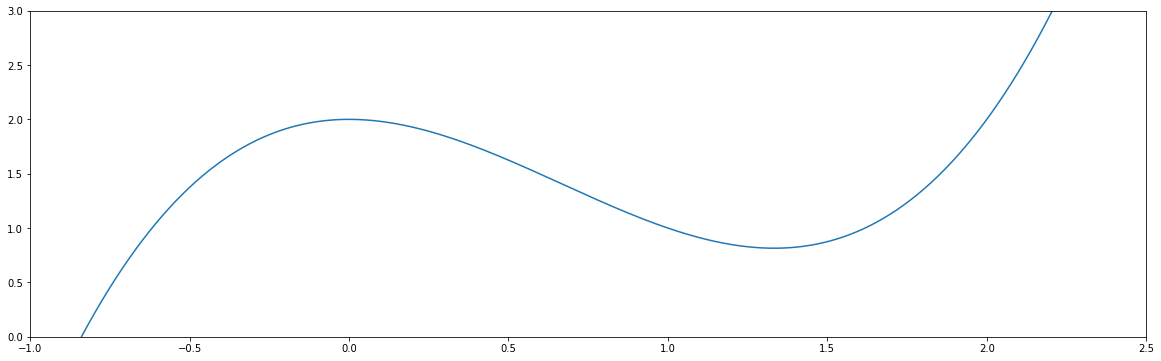

In [ ]:
f = lambda x: x**3-2*x**2+2
x = numpy.linspace(-1,2.5,1000)
plt.figure(figsize=[20,6])
plt.plot(x,f(x))
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.show()

In [ ]:
x_old = 0
x_new = 2 # The algorithm starts at x=2
n_k = 0.1 # step size
precision = 0.0001

x_list, y_list = [x_new], [f(x_new)]

# returns the value of the derivative of our function
def f_prime(x):
    return 3*x**2-4*x
 
while abs(x_new - x_old) > precision:
  x_old = x_new
  s_k = -f_prime(x_old)
  x_new = x_old + n_k * s_k
  x_list.append(x_new)
  y_list.append(f(x_new))
print('Local minimum occurs at: ', x_new)
print('Number of steps: ', len(x_list))
plt.show()

Local minimum occurs at:  1.3334253508453249
Number of steps:  17


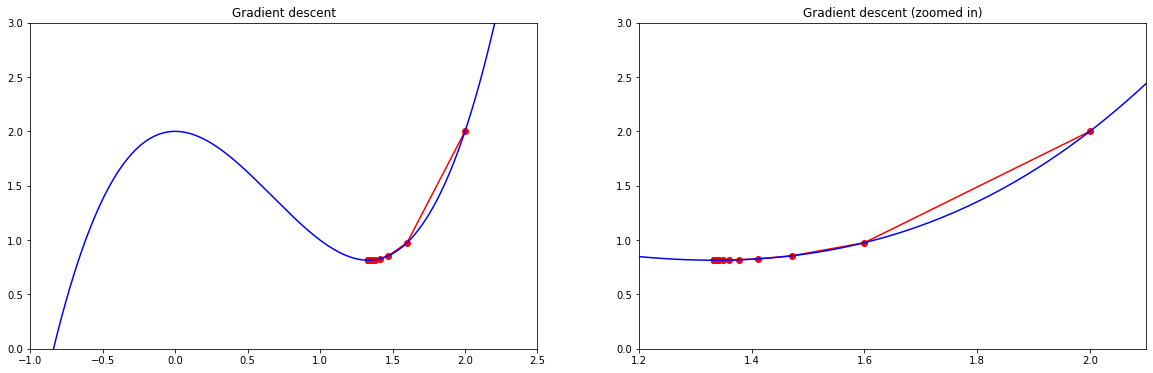

In [ ]:
plt.figure(figsize=[20,6])
plt.subplot(1,2,1)
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.title("Gradient descent")
plt.subplot(1,2,2)
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.xlim([1.2,2.1])
plt.ylim([0,3])
plt.title("Gradient descent (zoomed in)")
plt.show()

# Dataset: Univariate Gaussian Data with Unknown Parameters

If the dataset is generated from:
$$p( x; \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left (  \frac{- (x - \mu)^2}{2 \sigma^2} \right) $$
there is a constraint that needs to be enforced for $\sigma > 0$. Analytically solving for $\hat{\sigma}_{\mathsf{MLE}}$ does not need to worry about this but numerically optimizing for $\sigma$ either requires adding in 1) Lagrange multiplier term; or 2) taking care of the boundary condition of $\sigma > 0$
in other manners.

Instead generate from:
$$p( x; \mu, \sigma_{\mathsf{log}}) = \frac{1}{\sqrt{2 \pi \exp(\sigma_{\mathsf{log}})}} \exp \left (  \frac{- (x - \mu)^2}{2 \exp(\sigma_{\mathsf{log}})} \right) $$
This form lets you perform unconstrained optimization over $(\mu, \sigma_{\mathsf{log}})$ because $\sigma_{\mathsf{log}}$ can take any values.

In [ ]:
# Generate some random numbers from the univariate Gaussian.
log_scale = numpy.log(2.0)
true_parameter = numpy.array([-10, log_scale])
data = numpy.random.normal(loc=true_parameter[0], scale=numpy.exp(true_parameter[1]), size=1000)
print('This data is generated from mu = ', true_parameter[0], ' sigma = ', true_parameter[1])

This data is generated from mu =  -10.0  sigma =  0.6931471805599453


# Negative Log Likelihood



In [ ]:
# Negative log likelihood function.
# The theta is a numpy array with two components: mu and ln(sigma^2).
# The last is the numpy data set (1-D)
def gaussian_neg_loglikelihood(theta, data):
  num_points = data.shape[0]
  mu, log_scale_sigma = theta
  loglikelihood = - num_points / 2.0 * numpy.log(2 * numpy.pi)
  loglikelihood = loglikelihood - num_points * log_scale_sigma
  loglikelihood = loglikelihood - \
    1 / (2 * numpy.exp(log_scale_sigma)) * sum( (data - mu) ** 2 )
  return - loglikelihood

(400,)
(20,)
(20, 20) (20, 20) (20, 20)
-60 30


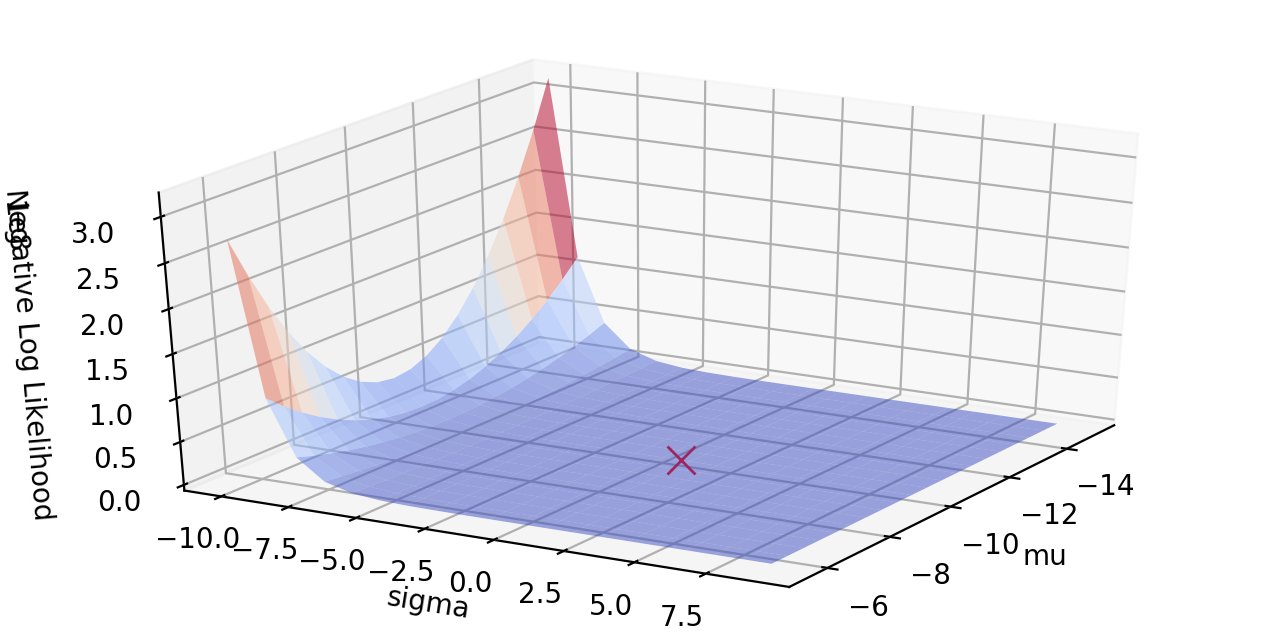

In [ ]:
# Plot
fig = plt.figure(figsize=(8,4), dpi=200)
ax = fig.add_subplot(111, projection='3d')
x = numpy.arange(-15, -5, 0.5)
y = numpy.arange(-10, 10, 1)
X, Y = numpy.meshgrid(x, y)
print(numpy.ravel(X).shape)
print(x.shape)

def fun(x, y, data):
  return numpy.array([
    gaussian_neg_loglikelihood((x_value, y_value), data) for x_value, y_value in zip(x,y) ])
zs = numpy.array(fun(numpy.ravel(X), numpy.ravel(Y), data))
Z = zs.reshape(X.shape)
print(Z.shape, Y.shape, X.shape)

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha=0.5)

ax.set_xlabel('mu')
ax.set_ylabel('sigma')
ax.set_zlabel('Negative Log Likelihood')

# Get current rotation angle
print (ax.azim, ax.elev)
 
# Set rotation angle to 30 degrees
ax.view_init(azim=30)
plt.plot([-10], [log_scale], 'rx', markersize=10)
plt.show()

# Gradient of Negative Log Likelihood

In [ ]:
# Negative log likelihood function gradient (consists of partial derivatives).
# The first component is the partial with respect to mu.
# The second component is the partial with respect to sigma.
def gaussian_neg_loglikelihood_grad(theta, data):
  num_points = data.shape[0]  
  mu, log_scale_sigma = theta
  grad = numpy.zeros((2,))

  # The partial with respect to mu.
  grad[0] = 1.0 / numpy.exp(log_scale_sigma) * sum( data - mu )
  
  # The partial with respect to sigma.
  grad[1] = -num_points  + 0.5 / numpy.exp(log_scale_sigma) * sum((data - mu) ** 2)

  return - grad

# Optimizing the Negative Log Likelihood
We can use scipy's optimizer which can choose adaptive learning rate.

In [ ]:
# Initial iterate: the first is mu, the second is sigma.
theta = numpy.array([0.0, 10.0])

# Call the optimizer.
res = minimize(
    gaussian_neg_loglikelihood, theta, 
    jac=gaussian_neg_loglikelihood_grad, args=(data,))
print(res)

      fun: 2665.7577652330638
 hess_inv: array([[ 2.11187898e-03, -3.14002781e-08],
       [-3.14002781e-08,  1.00000184e-03]])
      jac: array([ 5.65941429e-09, -1.73713488e-10])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 12
     njev: 20
   status: 0
  success: True
        x: array([-10.02404614,   0.74681923])


# Gradient Descent for Gaussian MLE Example

In [ ]:
# Takes the initial iterate with the first component = mu, the second component = sigma
# The second argument is the dataset.
def gradient_descent_gaussian_mle(initial_iterate, data, num_epochs=1000, learning_rate=0.001):

  iterate = initial_iterate
  print('Initial iterate: ', iterate)
  obj_values = numpy.zeros((num_epochs,))
  for i, epoch in enumerate(range(num_epochs)):
    iterate = iterate - learning_rate * gaussian_neg_loglikelihood_grad(iterate, data)
    obj_values[i] = gaussian_neg_loglikelihood(iterate, data)

  return iterate, obj_values

theta = numpy.array([0.0, 1.0])
final_iterate, obj_values = gradient_descent_gaussian_mle(theta, data)
print('Final iterate: ', final_iterate, ' vs true parameter: ', true_parameter)
print()
print('Last obj values: ', obj_values[-40:])

Initial iterate:  [0. 1.]
Final iterate:  [-10.02404614   0.74681923]  vs true parameter:  [-10.           0.69314718]

Last obj values:  [2665.75776523 2665.75776523 2665.75776523 2665.75776523 2665.75776523
 2665.75776523 2665.75776523 2665.75776523 2665.75776523 2665.75776523
 2665.75776523 2665.75776523 2665.75776523 2665.75776523 2665.75776523
 2665.75776523 2665.75776523 2665.75776523 2665.75776523 2665.75776523
 2665.75776523 2665.75776523 2665.75776523 2665.75776523 2665.75776523
 2665.75776523 2665.75776523 2665.75776523 2665.75776523 2665.75776523
 2665.75776523 2665.75776523 2665.75776523 2665.75776523 2665.75776523
 2665.75776523 2665.75776523 2665.75776523 2665.75776523 2665.75776523]
